# Visualize the feature space analysis

We performed two analyses: UMAP and clustering using four feature spaces

1. All features
2. Feature selected features by traditional methods
3. Bortezomib signature features
4. All features except bortezomib signature features

We create a figure here to visualize the differences qualitatively and quantitatively.

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))

In [2]:
# Output file
output_file <- file.path("figures", "feature_space_comparison.png")

In [3]:
# Load singscore results
singscore_file <- file.path("../3.resistance-signature/results/singscore/singscore_resultsbortezomib.tsv.gz")

singscore_df <- readr::read_tsv(
    singscore_file,
    col_types = readr::cols(
        Metadata_Plate = "c",
        Metadata_Well = "c",
        Metadata_batch = "c",
        TotalScore = "d"
    )
) %>%
    dplyr::select(
        Metadata_Plate,
        Metadata_Well,
        Metadata_batch,
        Metadata_dataset,
        TotalScore
    )

print(dim(singscore_df))
head(singscore_df, 3)

[1] 525   5


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_dataset,TotalScore
<chr>,<chr>,<chr>,<chr>,<dbl>
219907,B02,2021_03_03_Batch12,bortezomib,-0.15194809
219907,B03,2021_03_03_Batch12,bortezomib,-0.03125574
219907,B04,2021_03_03_Batch12,bortezomib,0.00999497


In [4]:
# Load umap summary and process
umap_file <- file.path("results", "umap_feature_summary.tsv.gz")

umap_df <- readr::read_tsv(
    umap_file,
    col_types = readr::cols(
        Metadata_Plate = "c",
        Metadata_Well = "c",
        Metadata_batch = "c"
    )
    )%>%
    dplyr::inner_join(
        singscore_df,
        by = c("Metadata_Plate", "Metadata_Well", "Metadata_batch"),
        relationship = "many-to-many"
    )

umap_df$Metadata_umap_category <- dplyr::recode(
    umap_df$Metadata_umap_category,
    all_features = "All features",
    feature_selected = "Feature selected",
    all_except_bortezomib_signature_features = "All except BZ",
    bortezomib_signature_features = "BZ features",
    random_45_features = "Random features"
)

umap_df <- umap_df %>%
    dplyr::filter(Metadata_umap_category != "All except BZ")

umap_df$Metadata_umap_category <- factor(
    umap_df$Metadata_umap_category,
    levels = c("All features", "Feature selected", "Random features", "BZ features")
)

print(dim(umap_df))
head(umap_df, 3)

[1] 2116   21


umap_0,umap_1,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,⋯,Metadata_plate_filename,Metadata_plate_map_name,Metadata_time_to_adhere,Metadata_treatment,Metadata_treatment_shorthand_from_plate_graph,Metadata_treatment_time,Metadata_clone_type,Metadata_umap_category,Metadata_dataset,TotalScore
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>
5.674817,3.613967,219901,B02,2021_03_03_Batch14,3404,2.5x10^3 cells/well,1,WT_parental,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,wildtype,All features,bortezomib,0.04934260
10.290071,2.441329,219901,B03,2021_03_03_Batch14,1726,2.5x10^3 cells/well,2,CloneA,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,resistant,All features,bortezomib,-0.02464514
10.387980,1.467352,219901,B04,2021_03_03_Batch14,2423,2.5x10^3 cells/well,3,CloneE,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,resistant,All features,bortezomib,0.01294887


In [5]:
# Load the clustering results and process for plotting
cluster_file <- file.path("results", "clustering_feature_summary.tsv.gz")

cluster_df <- readr::read_tsv(
    cluster_file, show_col_types = FALSE
) %>%
    dplyr::select(!average_p_value) %>%
    tidyr::pivot_longer(
        cols = c("silhouette_width", "average_enrichment", "maximum_enrichment"),
        names_to = "clustering_metric",
        values_to = "clustering_metric_value"
    ) 

cluster_df$feature_category <- dplyr::recode(
    cluster_df$feature_category,
    all_features = "All features",
    feature_selected = "Feature selected",
    all_except_bortezomib_signature_features = "All except BZ",
    bortezomib_signature_features = "BZ features",
    random_45_features = "Random 45 features"
)

cluster_df <- cluster_df %>%
    dplyr::filter(feature_category != "All except BZ")

cluster_df$feature_category <- factor(
    cluster_df$feature_category,
    levels = c("All features", "Feature selected", "Random 45 features", "BZ features")
)

cluster_df$clustering_metric <- dplyr::recode(
    cluster_df$clustering_metric,
    silhouette_width = "Silhouette width",
    average_enrichment = "Average odds ratio",
    maximum_enrichment = "Max cluster odds ratio"
)

cluster_df$clustering_metric <- factor(
    cluster_df$clustering_metric,
    levels = c("Average odds ratio", "Max cluster odds ratio", "Silhouette width")
)

print(dim(cluster_df))
head(cluster_df, 3)

[1] 156   4


k,feature_category,clustering_metric,clustering_metric_value
<dbl>,<fct>,<fct>,<dbl>
2,All features,Silhouette width,0.2708291
2,All features,Average odds ratio,1.1703583
2,All features,Max cluster odds ratio,1.7784197


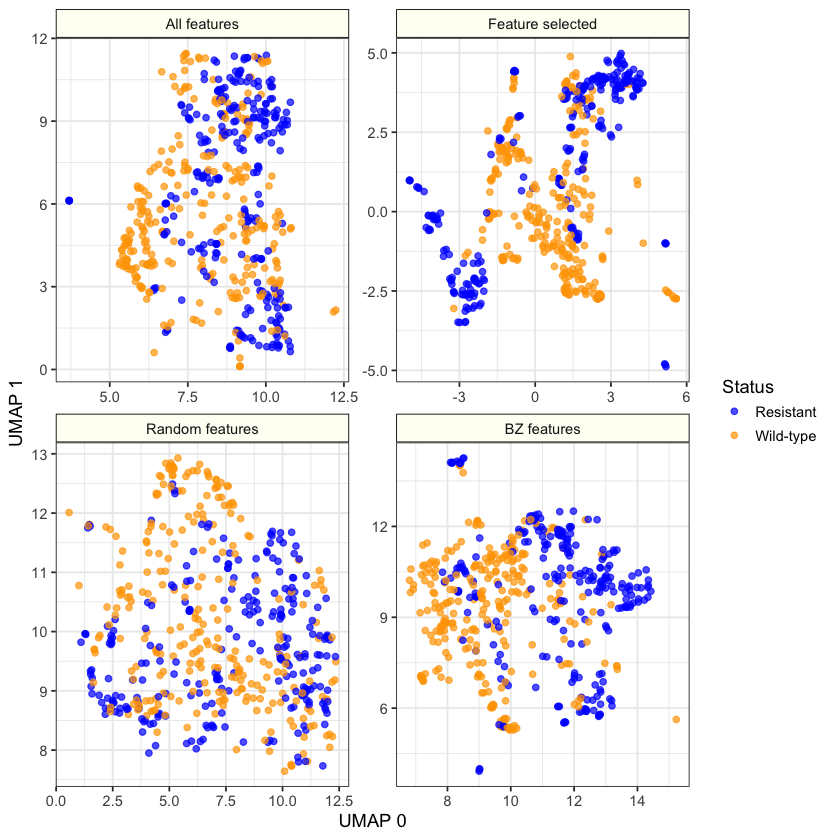

In [6]:
panel_status_gg <- (
    ggplot(
        umap_df,
        aes(x = umap_0, y = umap_1)
    )
    + geom_point(aes(color = Metadata_clone_type), alpha = 0.7)
    + facet_wrap("~Metadata_umap_category", scales="free")
    + theme_bw()
    + labs(x = "UMAP 0", y = "UMAP 1")
    + theme(
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
    + scale_color_manual(
        name = "Status",
        labels = c("resistant" = "Resistant", "wildtype" = "Wild-type"),
        values = c("resistant" = "blue", "wildtype" = "orange")
    )
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
)

panel_status_gg

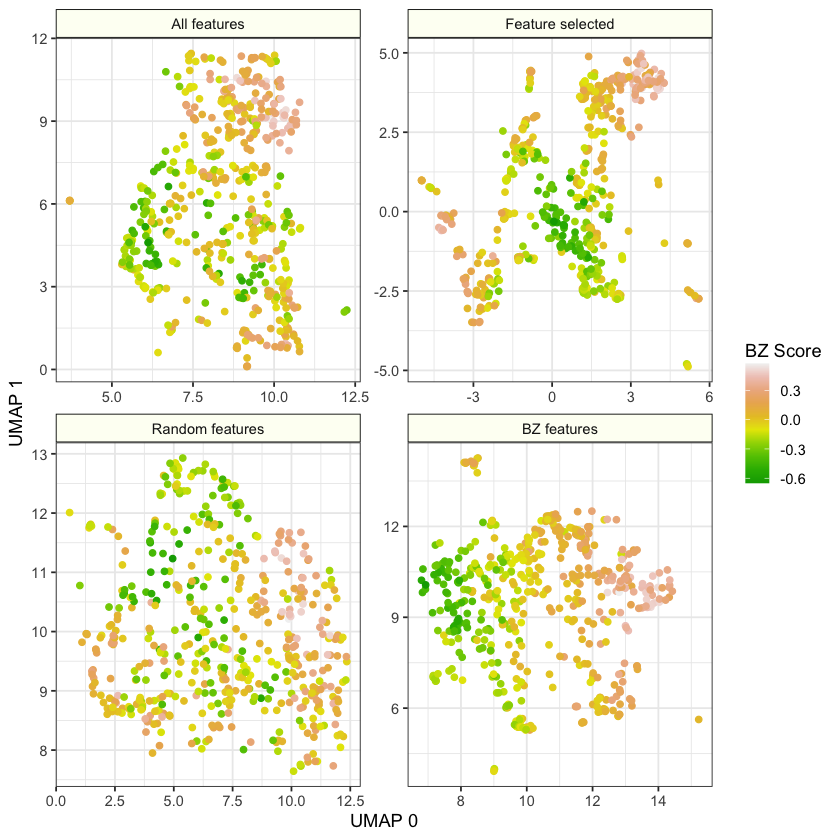

In [7]:
panel_score_gg <- (
    ggplot(
        umap_df,
        aes(x = umap_0, y = umap_1)
    )
    + geom_point(aes(color = TotalScore))
    + facet_wrap("~Metadata_umap_category", scales="free")
    + theme_bw()
    + labs(x = "UMAP 0", y = "UMAP 1")
    + theme(
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
    + scale_colour_gradientn(
        name = "BZ Score",
        colors = terrain.colors(10)
    )
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
)

panel_score_gg

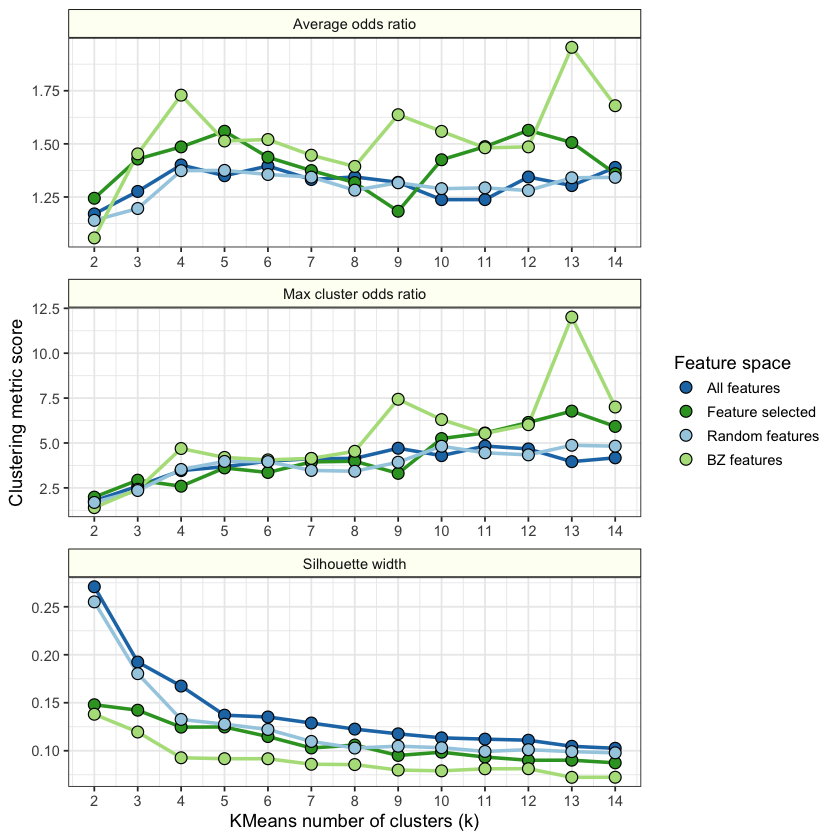

In [8]:
cluster_gg <- (
    ggplot(
        cluster_df,
        aes(
            x = k,
            y = clustering_metric_value,
            fill = feature_category,
            color = feature_category
        )
    )
    + geom_line(lwd = 1, show.legend = F)
    + geom_point(
        shape = 21,
        color = "black",
        size = 3
    )
    + theme_bw()
    + facet_wrap("~clustering_metric", nrow = 3, scales = "free")
    + scale_fill_manual(
        name = "Feature space",
        labels = c(
            "All features" =  "All features",
            "Feature selected" = "Feature selected",
            "Random 45 features" = "Random features",
            "BZ features" = "BZ features"
        ),
        values = c(
            "All features" =  "#1f78b4",
            "Feature selected" = "#33a02c",
            "Random 45 features" = "#a6cee3",
            "BZ features" = "#b2df8a"
        )
    )
    + scale_color_manual(
        name = "Feature space",
        labels = c(
            "All features" =  "All features",
            "Feature selected" = "Feature selected",
            "Random 45 features" = "Random features",
            "BZ features" = "BZ features"
        ),
        values = c(
            "All features" =  "#1f78b4",
            "Feature selected" = "#33a02c",
            "Random 45 features" = "#a6cee3",
            "BZ features" = "#b2df8a"
        )
    )
    + scale_size_continuous(
        name = "Fisher's\nOdds ratio"
    )
    + scale_x_continuous(breaks = seq(min(cluster_df$k), max(cluster_df$k), 1))
    # Decrease spacing in legend
    + theme(
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(x = "KMeans number of clusters (k)", y = "Clustering metric score")
)

cluster_gg

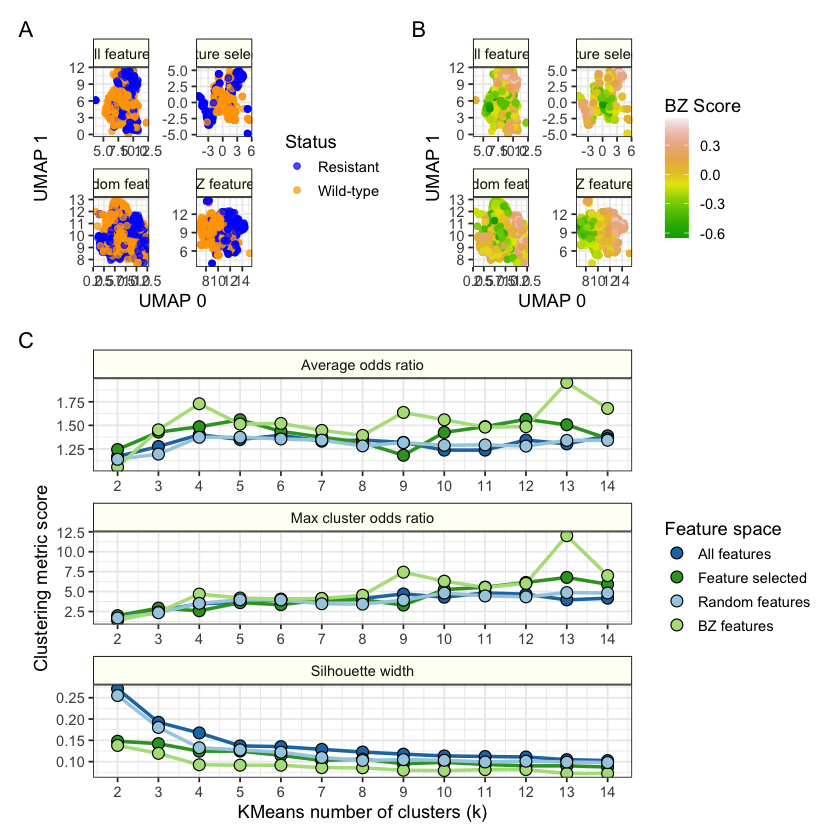

In [9]:
patchwork_plot <- (
    (
        panel_status_gg
        + panel_score_gg
    )
    / cluster_gg
)

patchwork_plot <- (
    patchwork_plot 
    + plot_annotation(tag_levels = "A")
    + plot_layout(heights = c(0.5, 1))
)

ggsave(output_file, patchwork_plot, height = 9, width = 9, dpi = 500)

patchwork_plot